In [1]:
from retrieve import Basket
from retrieve import RecommendTicker
import bt

symbols = list(Basket().get_portfolio().keys())

symbols.extend(RecommendTicker().recommend_tickers())

df = bt.get(symbols,start="2020-01-01")

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ECC%20%20%20%20%20%20%20%20%20%20%20?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ECC+++++++++++&crumb=oq5XMMdoy35
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SAND%20%20%20%20%20%20%20%20%20%20?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SAND++++++++++&crumb=oq5XMMdoy35


yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


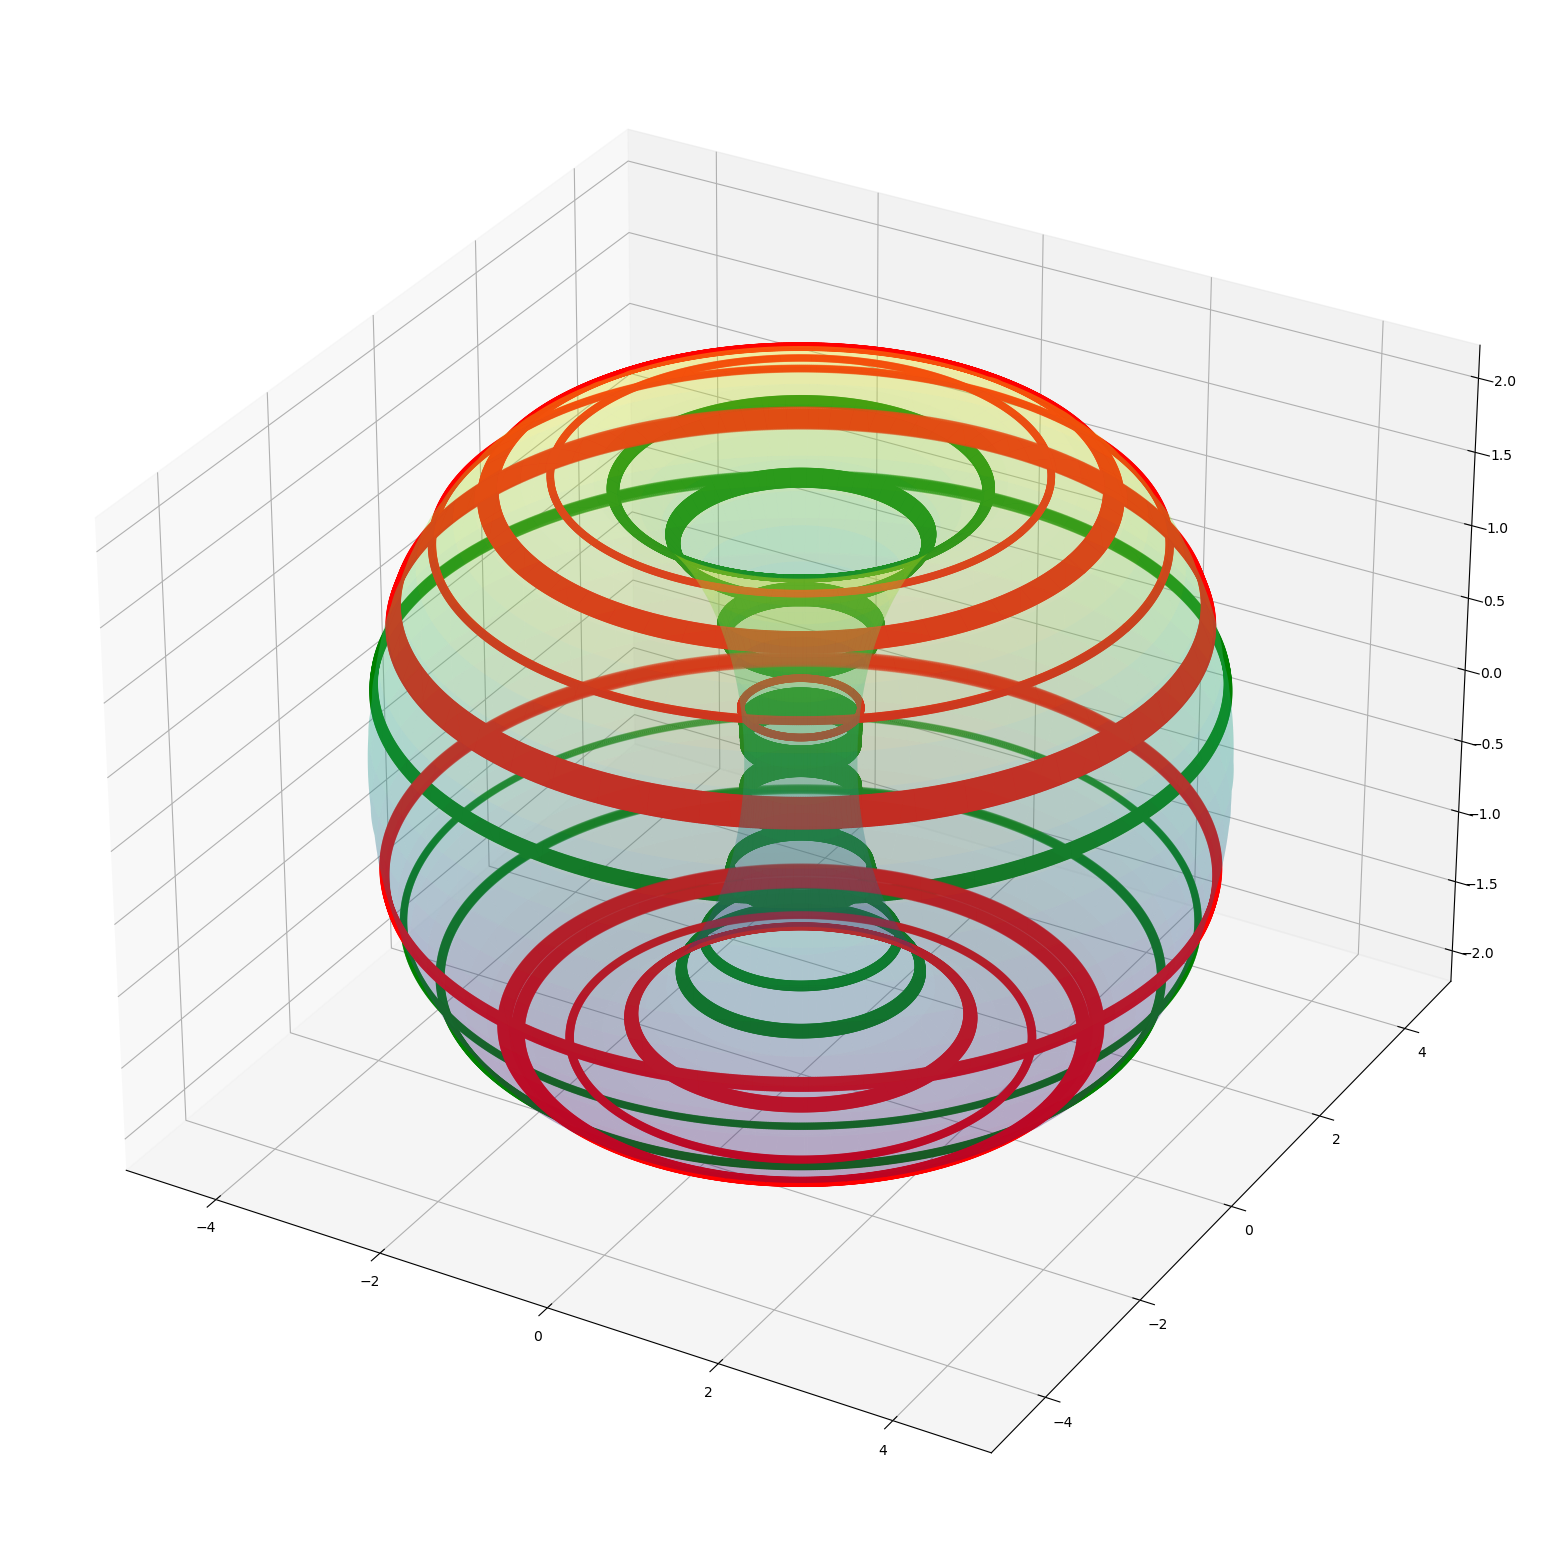

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_torus(ticker,big,rolling_mean,rolling_std,buy_signal,sell_signal,size):
    # Define parametric equations for a torus
    def torus_parametric(u, v, R, r):
        x = (R + r * np.cos(v)) * np.cos(u)
        y = (R + r * np.cos(v)) * np.sin(u)
        z = r * np.sin(v)
        return x, y, z

    # Parameters for the torus
    R = (rolling_mean[ticker] + (2 * rolling_std[ticker])).mean()  # Major radius
    r = rolling_mean[ticker].mean()  # Minor radius

    # Generate torus coordinates
    u = np.linspace(0,big,size)
    v = np.linspace(0,big,size)
    U, V = np.meshgrid(u, v)
    X, Y, Z = torus_parametric(U, V, R, r)

    # Plot the torus
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, alpha=0.2, cmap='viridis')

    # Plot the price data
    ax.scatter(X[buy_signal[ticker]], Y[buy_signal[ticker]], Z[buy_signal[ticker]], color='g', label='Buy Signal')
    ax.scatter(X[sell_signal[ticker]], Y[sell_signal[ticker]], Z[sell_signal[ticker]], color='r', label='Sell Signal')
    ax.tick_params(labelsize=10)
    
    plt.show()

big = 2*np.pi

df_filter = df - df.iloc[0]

norm_price = (df_filter - df_filter.min()) / (df_filter.max() - df_filter.min()) * big

rolling_mean = norm_price.rolling(window=50).mean()
rolling_std = norm_price.rolling(window=50).std()

buy_signal = norm_price < rolling_mean - (2 * rolling_std)
sell_signal = norm_price > rolling_mean + (2 * rolling_std)

plot_torus("cdlx",big,rolling_mean,rolling_std,buy_signal,sell_signal,len(df))

In [3]:
def action_tickers(ticker,buy_indicator,sell_indicator):
    tick_buy = pd.DataFrame(buy_indicator[ticker])
    tick_buy["BuySignal"] = "Buy"
    tick_buy = tick_buy.rename(columns={ticker:"BuyAction"})

    tick_sell = pd.DataFrame(sell_indicator[ticker])
    tick_sell["SellSignal"] = "Sell"
    tick_sell = tick_sell.rename(columns={ticker:"SellAction"})

    actions = pd.concat([tick_buy,tick_sell],axis=1)
                     
    actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

    buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
    sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
    hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

    actions = pd.concat([buy,sell,hold],axis=0).reset_index()

    actions.columns = ["Date", ticker + "Signal"]

    actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

    actions = actions.drop(["Date"],axis=1)

    return actions

ticker_action = pd.DataFrame(buy_signal.index)

for tick in symbols:
    ticker_action[tick.lower() + "Signal"] = action_tickers(tick.lower(),buy_signal,sell_signal)

date = ticker_action.pop("Date")
ticker_action = ticker_action.set_index(date)

ticker_action.iloc[51:]

,cdlxSignal,cvxSignal,pyplSignal,modSignal,calmSignal,indaSignal,anfSignal,sigaSignal
Date,,,,,,,,
2020-03-17,Hold,Buy,Buy,Buy,Sell,Buy,Buy,Hold
2020-03-18,Buy,Buy,Buy,Buy,Hold,Buy,Buy,Buy
2020-03-19,Buy,Buy,Buy,Buy,Hold,Buy,Buy,Hold
2020-03-20,Buy,Buy,Buy,Buy,Hold,Buy,Buy,Hold
2020-03-23,Buy,Buy,Buy,Buy,Hold,Buy,Buy,Hold
...,...,...,...,...,...,...,...,...
2024-06-21,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2024-06-24,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2024-06-25,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold


sellTailAction
0% [############################# ] 100% | ETA: 00:00:00

<Axes: title={'center': 'Equity Progression'}>

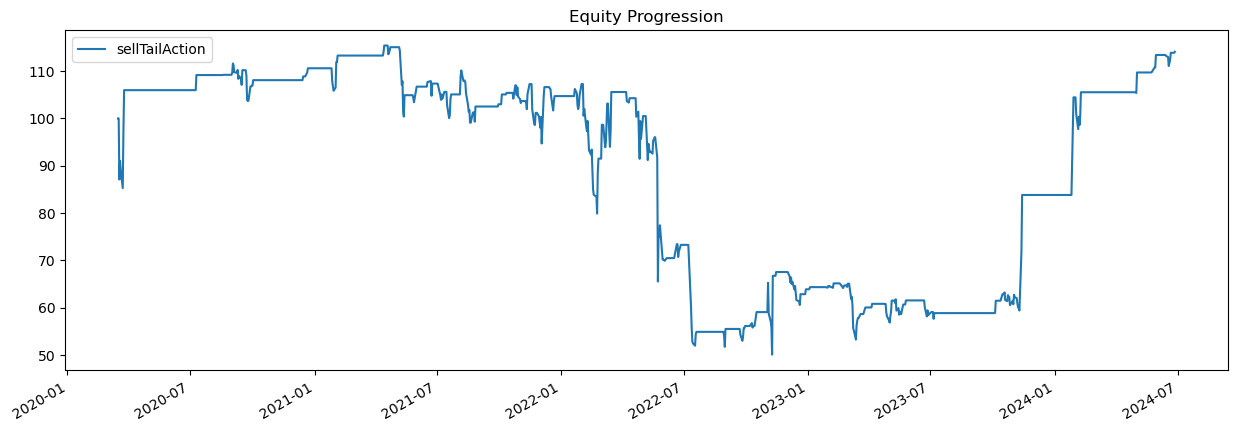

In [4]:
strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(buy_signal),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df.iloc[51:,:],integer_positions=False, progress_bar=True)

res = bt.run(t2)
res.plot()

<Axes: title={'center': 'Equity Progression'}>

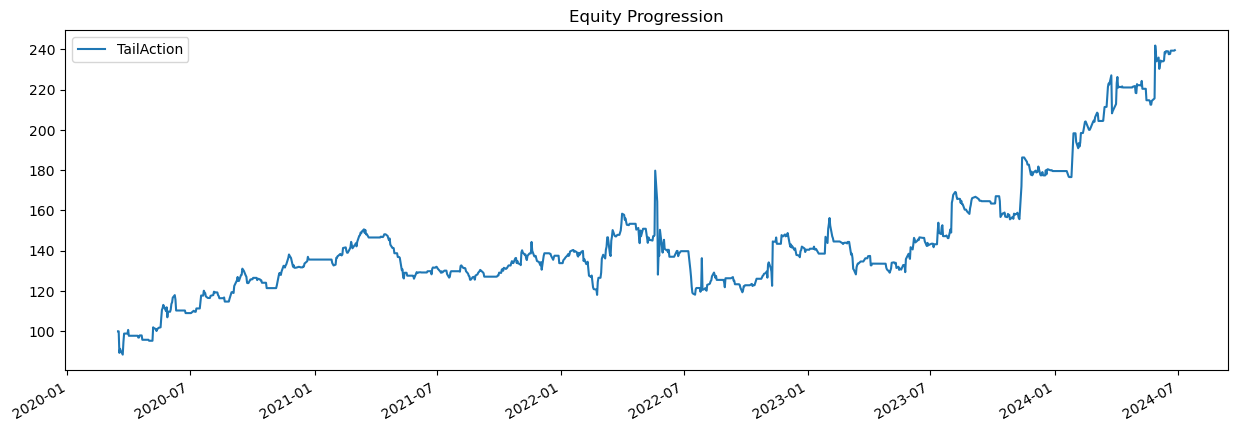

In [5]:
strat1 = bt.Strategy('buyTailAction', [bt.algos.SelectWhere(buy_signal),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t1 = bt.Backtest(strat1, df.iloc[51:,:],integer_positions=False, progress_bar=True)

strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(sell_signal),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df.iloc[51:,:],integer_positions=False, progress_bar=True)

tests = [t1,t2]

combined_strat = bt.Strategy('TailAction', [bt.algos.SelectAll(),
                                            bt.algos.WeighEqually(),
                                            bt.algos.Rebalance()],
                                            children = [x.strategy for x in tests])

combined_test = bt.Backtest(
    combined_strat,
    df.iloc[51:,:],
    integer_positions = False,
    progress_bar = False
)

res = bt.run(combined_test)

res.plot()

In [6]:
res.stats

,TailAction
start,2020-03-16 00:00:00
end,2024-06-27 00:00:00
rf,0.0
total_return,1.395381
cagr,0.226302
max_drawdown,-0.34252
calmar,0.660698
mtd,0.023659
three_month,0.144688
six_month,0.33103


In [7]:
import json
import requests
import os
import yfinance as yf

criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

tickers = list(criteria["Portfolio Weights"].keys())

for stock_ex in criteria["Exchanges"]:
    github_branch = "https://raw.githubusercontent.com/rreichel3/US-Stock-Symbols/main"
    exchange =  "/" + stock_ex + "/" + stock_ex + "_full_tickers.json" 

    url = github_branch + exchange # combining the repository dataset with the specific exchange

    resp = requests.get(url)
    data = json.loads(resp.text)

    for i in range(len(data)):
        ticker = data[i]

        immediate_criteria = list(criteria["Immediate Criteria"].keys()) # ["lastsale", "volume", "marketCap"]
        
        # important to note that since the list of tickers is massive, need to find any method to narrow scope

        # Step 1: Check to see if anything is blank from the full json file or ticker already in portfolio
        if ticker["symbol"] in tickers or any(ticker[checker] == "" for checker in immediate_criteria): 
            continue

        # numeric comparison
        lastsale = float(ticker[immediate_criteria[0]][1:])
        volume = float(ticker[immediate_criteria[1]])
        marketCap = float(ticker[immediate_criteria[2]])

        # Step 2: eliminate low cost stocks, less volume, and bound the marketcap due to portfolio size
        check_1 = lastsale > criteria["Immediate Criteria"][immediate_criteria[0]] \
            and volume > criteria["Immediate Criteria"][immediate_criteria[1]]
            
        check_2 = marketCap <= criteria["Immediate Criteria"][immediate_criteria[2]]

        if check_1 and check_2:
            greater = criteria["Portfolio Criteria"]["Greater"]
            less_than = criteria["Portfolio Criteria"]["Less Than"]

            symbol = ticker["symbol"]

            # list of metrics for criteria
            metrics = list(greater.keys())
            metrics.extend(list(less_than.keys()))

            values = dict(filter(lambda item: item[0] in metrics, yf.Ticker(symbol).info.items()))
            
            try:
                # Step 3: select tickers whick satisfy all of these conditions
                check_3 = all(values[metric] > x for metric,x in greater.items()) 
                check_4 = all(values[metric] < x for metric,x in less_than.items())
                if check_3 and check_4:
                    tickers.append(symbol)

            except KeyError:
                continue

print(tickers)

['CDLX', 'CVX', 'PYPL', 'MOD', 'CALM', 'INDA', 'ANF', 'SIGA']


In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt

a = yf.Ticker("AAPL").income_stmt
b = yf.Ticker("AAPL").cash_flow
c = yf.Ticker("AAPL").balance_sheet

inital = ["Net Income", "EBIT", "Tax Provision", "Depreciation And Amortization", "Capital Expenditure", 
          "Change In Working Capital", "Cash And Cash Equivalents", "Total Debt", "Ordinary Shares Number"]

f = pd.concat([a,b,c],axis=0)
f = f.loc[f.index.isin(inital)]

f = f.dropna(axis=1).T
f = (f[inital]/1000000).reset_index()

f

# f.insert(0,"Year",[int(val.strftime("%Y")) for val in f["index"].tolist()])
# start = dt.date.today().year-1

# f = f.drop("index",axis=1)

# cash = f.loc[f["Year"] == start,"Cash And Cash Equivalents"].values.tolist()[0]
# debt = f.loc[f["Year"] == start,"Total Debt"].values.tolist()[0]
# shares = f.loc[f["Year"] == start,"Ordinary Shares Number"].values.tolist()[0]

# f = f.drop(inital[6:],axis=1)

# g = pd.DataFrame()

# g["Year"] = f["Year"]-start

# f = f.iloc[::-1].reset_index(drop=True)

# g["Net Income"] = (f["Net Income"]/f["Net Income"].shift(1))-1


# g["EBIT"] = f["EBIT"]/f["Net Income"]

# for a in inital[2:6]:
#     g[a] = f[a]/f["EBIT"]

# g["Net Income"] = g["Net Income"].fillna(0)
# g = g.set_index("Year").T

# f = f.reset_index(drop=True).set_index("Year").T

# for i,k in zip(range(0,5,1), range(start,start+5,1)):
#     v = [j for j in range(g.columns.tolist()[i],i+1,1)]
#     g[i+1] = g[v].mean(axis=1)
#     f[k+1] = f[k] * (1+g[i+1])

# cols1 = f.columns.tolist()
# cols1 = np.array(cols1[cols1.index(start+1):])

# f = f[cols1]

# add_values = (f.loc[f.index == inital[1]].values + f.loc[f.index == inital[3]].values).astype(float)
# subtract_values = (f.loc[f.index == inital[2]].values - f.loc[f.index == inital[4]].values \
#                     - f.loc[f.index == inital[5]].values).astype(float)

# unlevered_fcf =  np.round(add_values-subtract_values,1)

# cols2 = g.columns.tolist()
# cols2 = np.array(cols2[cols2.index(1):])

# pv_fcf = unlevered_fcf/((1+.15)**cols2)

# tv = round((unlevered_fcf.flatten().tolist()[-1]*(1+.15))/(.15-.03),1)

# pv_tv = round(tv/((1+.15)**cols2.flatten().tolist()[-1]),1)

# enterprise_value = round(pv_tv + pv_fcf.sum(),1)

# fair_value = (enterprise_value+cash-debt)/shares

# fair_value

,index,Net Income,EBIT,Tax Provision,Depreciation And Amortization,Capital Expenditure,Change In Working Capital,Cash And Cash Equivalents,Total Debt,Ordinary Shares Number
0,2020-09-30,57411.0,69964.0,9680.0,11056.0,-7309.0,5690.0,38016.0,112436.0,16976.763
1,2021-09-30,94680.0,111852.0,14527.0,11284.0,-11085.0,-4911.0,34940.0,124719.0,16426.786
2,2022-09-30,99803.0,122034.0,19300.0,11104.0,-10708.0,1200.0,23646.0,120069.0,15943.425
3,2023-09-30,96995.0,117669.0,16741.0,11519.0,-10959.0,-6577.0,29965.0,111088.0,15550.061


In [30]:
a

,2023-09-30,2022-09-30,2021-09-30,2020-09-30
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0
Tax Rate For Calcs,0.147,0.162,0.133,0.144
Normalized EBITDA,129188000000.0,133138000000.0,123136000000.0,81020000000.0
Net Income From Continuing Operation Net Minority Interest,96995000000.0,99803000000.0,94680000000.0,57411000000.0
Reconciled Depreciation,11519000000.0,11104000000.0,11284000000.0,11056000000.0
Reconciled Cost Of Revenue,214137000000.0,223546000000.0,212981000000.0,169559000000.0
EBITDA,129188000000.0,133138000000.0,123136000000.0,81020000000.0
EBIT,117669000000.0,122034000000.0,111852000000.0,69964000000.0
Net Interest Income,-183000000.0,-106000000.0,198000000.0,890000000.0
Interest Expense,3933000000.0,2931000000.0,2645000000.0,2873000000.0


In [10]:
b.head(n=60)

,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2019-12-31
Free Cash Flow,19780000000.0,37628000000.0,21131000000.0,1655000000.0,NaN
Repurchase Of Capital Stock,-14939000000.0,-11255000000.0,-1383000000.0,-1757000000.0,NaN
Repayment Of Debt,-4340000000.0,-8742000000.0,-17384000000.0,-15684000000.0,NaN
Issuance Of Debt,285000000.0,263000000.0,4448000000.0,23154000000.0,NaN
Capital Expenditure,-15829000000.0,-11974000000.0,-8056000000.0,-8922000000.0,NaN
Interest Paid Supplemental Data,465000000.0,525000000.0,699000000.0,720000000.0,NaN
Income Tax Paid Supplemental Data,10416000000.0,9148000000.0,4355000000.0,2987000000.0,NaN
End Cash Position,9275000000.0,19121000000.0,6795000000.0,6737000000.0,NaN
Beginning Cash Position,19121000000.0,6795000000.0,6737000000.0,6911000000.0,NaN
Effect Of Exchange Rate Changes,-114000000.0,-190000000.0,-151000000.0,-50000000.0,NaN


In [11]:
b.tail(n=3)

,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2019-12-31
Gain Loss On Investment Securities,NaN,3855000000.0,3659000000.0,1543000000.0,-2073000000.0
Net Foreign Currency Exchange Gain Loss,578000000.0,-412000000.0,-7000000.0,619000000.0,NaN
Net Income From Continuing Operations,21411000000.0,35608000000.0,15689000000.0,-5561000000.0,NaN


In [12]:
c.head(n=60)

,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2019-12-31
Treasury Shares Number,577028776.0,527460237.0,512870523.0,517490263.0,NaN
Ordinary Shares Number,1865647804.0,1915216343.0,1929806057.0,1925186317.0,NaN
Share Issued,2442676580.0,2442676580.0,2442676580.0,2442676580.0,NaN
Net Debt,12024000000.0,5213000000.0,25232000000.0,38086000000.0,NaN
Total Debt,20836000000.0,23339000000.0,31369000000.0,44315000000.0,NaN
Tangible Book Value,156235000000.0,154560000000.0,134682000000.0,127286000000.0,NaN
Invested Capital,181159000000.0,182173000000.0,169939000000.0,175370000000.0,NaN
Working Capital,8870000000.0,16135000000.0,6947000000.0,3895000000.0,NaN
Net Tangible Assets,156235000000.0,154560000000.0,134682000000.0,127286000000.0,NaN
Capital Lease Obligations,634000000.0,448000000.0,497000000.0,633000000.0,NaN


In [13]:
c.tail(n=11)

,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2019-12-31
Prepaid Assets,NaN,3739000000.0,2849000000.0,3304000000.0,3407000000.0
Inventory,8612000000.0,8247000000.0,6795000000.0,5676000000.0,NaN
Finished Goods,6465000000.0,6381000000.0,4813000000.0,4033000000.0,NaN
Raw Materials,2147000000.0,1866000000.0,1982000000.0,1643000000.0,NaN
Receivables,19921000000.0,20456000000.0,18419000000.0,11471000000.0,NaN
Accounts Receivable,19921000000.0,20456000000.0,18419000000.0,11471000000.0,NaN
Allowance For Doubtful Accounts Receivable,-301000000.0,-457000000.0,-303000000.0,-284000000.0,NaN
Gross Accounts Receivable,20222000000.0,20913000000.0,18722000000.0,11755000000.0,NaN
Cash Cash Equivalents And Short Term Investments,8223000000.0,17901000000.0,5675000000.0,5627000000.0,NaN
Other Short Term Investments,45000000.0,223000000.0,35000000.0,31000000.0,NaN


In [14]:
yf.Ticker("GDDY").info

{'address1': '2155 East GoDaddy Way',
 'city': 'Tempe',
 'state': 'AZ',
 'zip': '85284',
 'country': 'United States',
 'phone': '480 505 8800',
 'website': 'https://www.godaddy.com',
 'industry': 'Software—Infrastructure',
 'sector': 'Technology',
 'longBusinessSummary': "GoDaddy Inc. engages in the design and development of cloud-based products in the United States and internationally. It operates through two segments: Applications and Commerce, and Core Platform. The Applications and Commerce segment provides applications products, including Websites + Marketing, a mobile-optimized online tool that enables customers to build websites and e-commerce enabled online stores; and Managed WordPress, a streamlined and optimized website building that allows customers to easily build and manage a faster WordPress site; Managed WooCommerce Stores to sell anything and anywhere online; and marketing tools and services, such as GoDaddy Studio mobile application, search engine optimization, Meta a

In [15]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol
ticker_symbol = 'GDDY'

# Get the balance sheet data
stock = yf.Ticker(ticker_symbol)
balance_sheet = stock.balance_sheet

# Transpose the balance sheet for easier manipulation
balance_sheet = balance_sheet.T

# Display the balance sheet data for referenc
# Update these lists with the correct column names identified from the balance sheet
current_assets_components = [
    'Cash And Cash Equivalents', 'Net Receivables', 'Inventory', 'Other Current Assets'
]

current_liabilities_components = [
    'Accounts Payable', 'Other Current Liabilities'
]

# Initialize lists to store net working capital and the change in net working capital
nwc_list = []
change_in_nwc_list = []

# Calculate net working capital for each year
for i in range(len(balance_sheet)):
    current_assets = sum(balance_sheet.loc[balance_sheet.index[i], component] 
                         for component in current_assets_components if component in balance_sheet.columns)
    current_liabilities = sum(balance_sheet.loc[balance_sheet.index[i], component] 
                              for component in current_liabilities_components if component in balance_sheet.columns)
    nwc = current_assets - current_liabilities
    nwc_list.append(nwc)

    if i > 0:
        change_in_nwc = nwc_list[i] - nwc_list[i - 1]
        change_in_nwc_list.append(change_in_nwc)

# Create a DataFrame to display the results
nwc_df = pd.DataFrame({
    'Year': balance_sheet.index[1:],  # Skipping the first year for change in NWC calculation
    'Net Working Capital': nwc_list[1:],  # Skipping the first year
    'Change in Net Working Capital': change_in_nwc_list
})

print(nwc_df)


        Year  Net Working Capital  Change in Net Working Capital
0 2022-12-31         5.750000e+08                    384900000.0
1 2021-12-31         1.030900e+09                    455900000.0
2 2020-12-31         5.060000e+08                   -524900000.0
3 2019-12-31                  NaN                            NaN
